# 03- Calculate the $\chi^2$ with the loop code

We now describe the use of the loop function that performs the chi square calculations between a grid of synthetic Stokes V profiles and the LSD profiles (`Packet.cutfit`)
 contained in a pyRaven observation packet. 

This is the most time-consuming part of pyRaven. For large grids, we suggest to run the loop function from a python script from the terminal, using the screen functionality. 

You will need to import the packages below

In [31]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import copy

import pyRaven as rav

## 1. What is the goal of this code?

The goal of this piece of the bayesian analysis is to create a synthetic Stokes V profile for each parameter set on a grid, and calculate the $\chi^2$ between this profile and the observations. These 4D grids of $\chi^2$ are saved as h5 files.

To run this piece of the code, we need 2 things:
* An observation <a href='../API/data.html#pyRaven.data.DataPacket'>`Packet` </a>
* A <a href='../API/params.html#pyRaven.params.parameters'>`Parameters`</a> dictionary that will contain:
    - **The ['general'] parameters** that define the Stokes I profile (see previous notebook), and the general information that is necessay for the Stokes V profile (e.g. the wavelength of the transition)
    - **The ['weak'] parameters** which contains the parameter for the weak-field solution (as opposed to the unno solution), namely the effective landé factor. 
        :::{Note}
        The loop function only performs weak-field calculation. 
        :::
    - **The ['grid'] parameters** which defines the grid of parameters for the dipolar field model (Bpole, beta, phi, incl -- see below)

The <a href='../API/loop.html#pyRave.lopp.loop'>`loop.loop`</a> function itself takes already loaded Observation <a href='../API/data.html#pyRaven.data.DataPacket'>`Packet` </a> object and <a href='../API/params.html#pyRaven.params.parameters'>`Parameters`</a> dictionary object. The loop function writes the $\chi^2$ files in the current directory but a path can be specified. 

Here's an example of a workflow doing the object loading directly:
```
Packet = rav.data.read_packet('../Data/hd12345.h5')
Params = rav.param.read_parameters('../Data/hd12345.h5')
rav.loop.loop(Packet, Params, path='loop_output/')
```

We also provide a wrapper function that will take filenames as input for the packet and the parameters dictionary, for example:
```
rav.loop.loop_wrapper('packet.h5', 'params.jason')
```

:::{Note}
This is the most time consuming part of the bayesian analysis. The larger your parameter grid, and the larger the star's vsini, the more time it will take. 
:::

The code outputs a message at the end of each of the outer-loop on the inclination angle, with the time spent (in seconds). 

To reduce memory usage, the code will output a chi2 file for each inclination angle value in the grid. It will furthermore create a separate file for each observations, and for each Stokes parameter. 
The file format is as follow: `chi[S]_i[i]obs[o].h5` where `[S]` is 'V' or 'N1', `[i]` is the index of the inclination value, and `[o]` is the index of the observation. 

For more information about the structure of a chi2 file, see the tutorial on the BayesObject class LINK!, or the class API (<a href='../API/BayesObjects.html#pyRaven.BayesObjects.chi'>`BayesObjects.chi`</a>)

## 2. Choice of grid parameters, and necessary other parameters

In this section, we discuss the parameters that are required by the loop code. 

We also discuss how to choose the grid of parameters for the dipolar field model. This includes:
* how to set the desired Lande factor
* how to decide on an upper limit for Bpole
* how to decide on a lower limit on the inclination angle. 

::::{margin}
:::{note}
As this is a tutorial, this section includes loading and visualzing the DataPacket and the models. Note that this is not strickly necessary for a pyRaven workflow. 
:::
::::
In the cell below, we load and display our example DataPacket from [](../SimpleApplication/01-DataSetup.ipynb), which contains 3 LSD profiles that have been scaled, normalized, and cut to include only the portion of the line profile that will be used for the calculation of the $\chi^2$ (right-hand graph). 

::::{margin}
:::{hint}
Here, we created an entire <a href='../API/params.html#pyRaven.params.parameters'>`Parameter`</a> dictionary from scratch to make things clear. In real life, we probably would simply load in the parameter file we created in the previous notebook, and add the additional necessary keys to the already loaded object. 
:::
::::
We also generate a <a href='../API/params.html#pyRaven.params.parameters'>`Parameters`</a> dictionary (explicitely) with the parameters we have decided upon in the previous notebook for the fit to the Stokes I profile. We overplot the fit in dashed black in the two right-hand panels. 

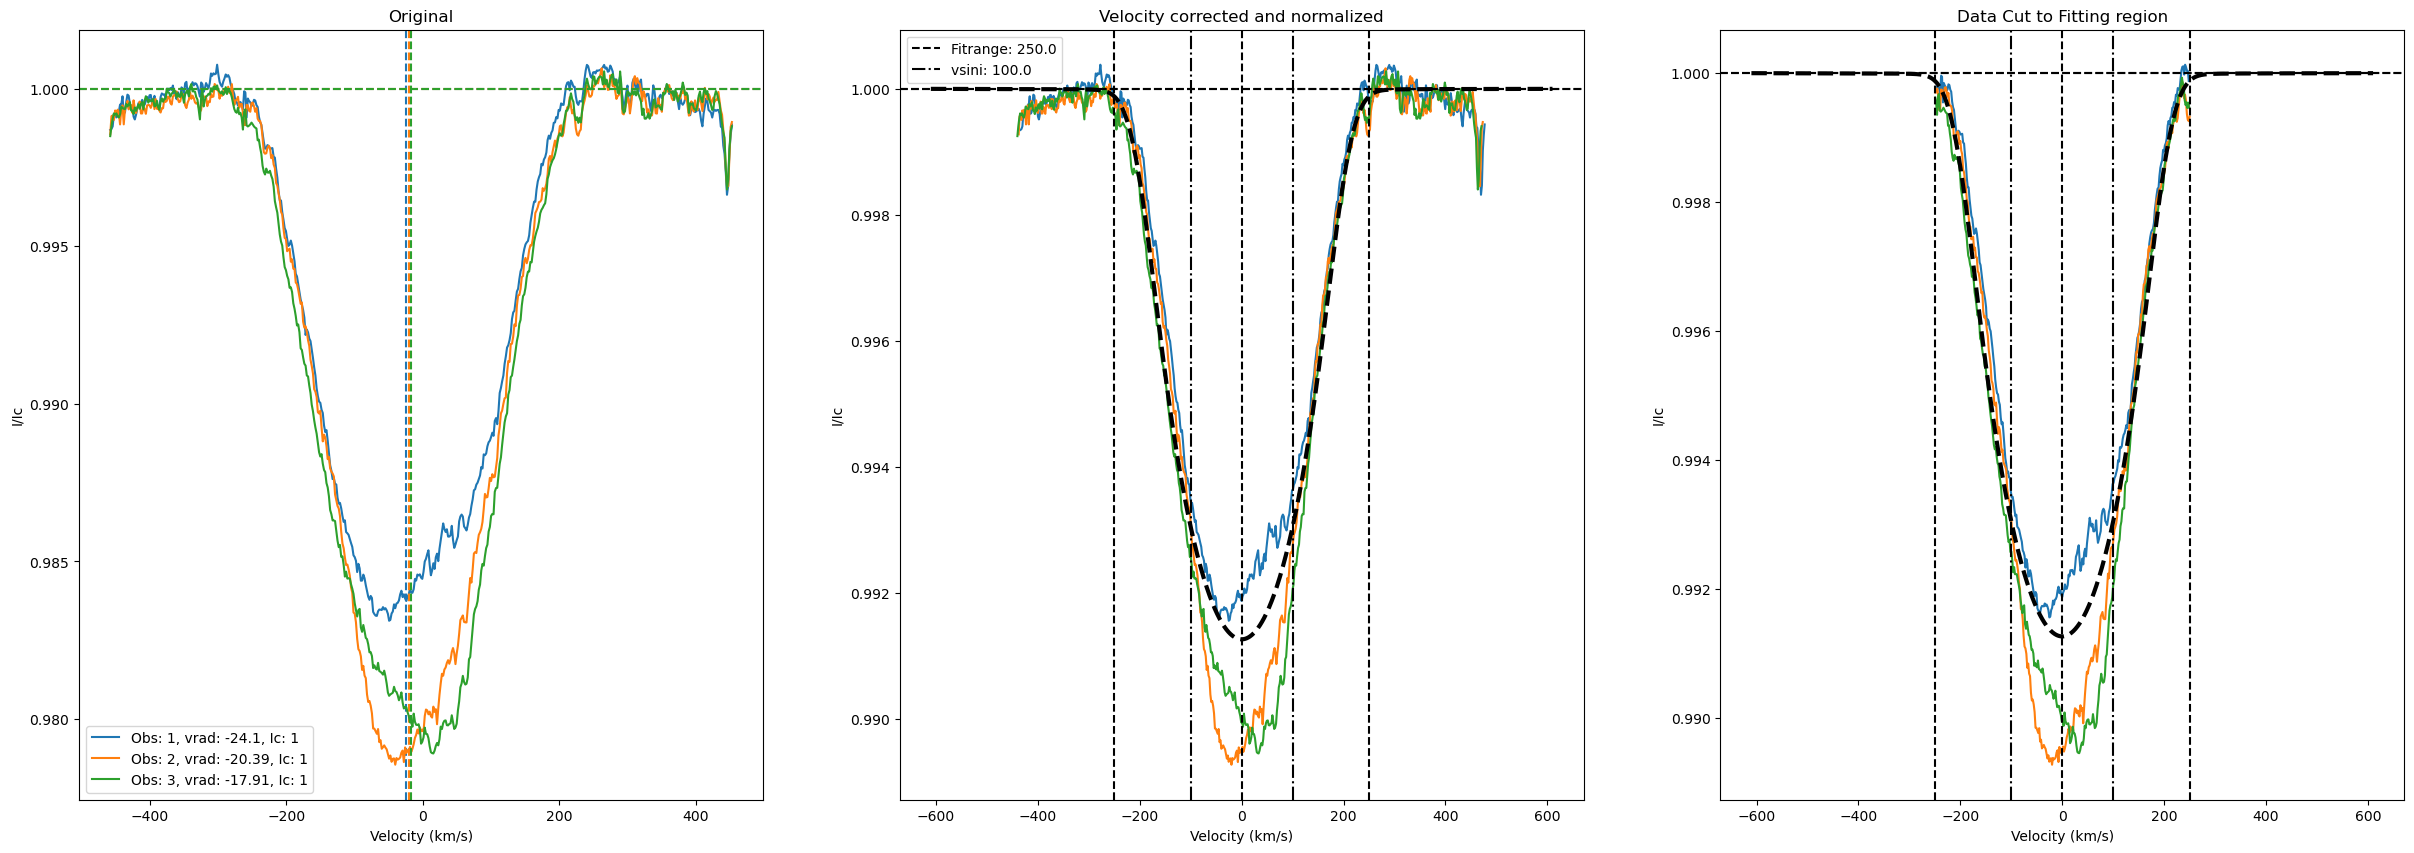

In [32]:
Packet = rav.data.read_packet('ExampleOutput/01-DataSetup/ExamplePacket.h5')
fig, ax = Packet.plotI()

# Parameters we have settled on in the previous notebook:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':200.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':-0.20,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'res':65000,
    'vmac':30,
  }
param={'general' : genparam
       }

# Calculate an analytical model and overplot on the last two graphs
# (not the first one, as the profiles have been normalized to continuum
# and scaled to the LSD weigths we have decided to use)
model = rav.diskint.analytical(param)
for item in ax[1:3]:
  item.plot(model['vel'], model['flux'], c='k', ls='--', lw=3)

### 2.1 Setting the Landé factor

For the calculation of the synthetic profiles with the weak-field approximation, we have to explicitly set the effective Landé factor. We have already set a wavelength of 5000 A in our 'general' parameter dictionary 
:::{note}
For Stokes I analytical calculation, this parameter is only used to create a wavelength dispersion axis in the output model.
::: 

This mean that when this wavelength is combined with the LSD weigths used in the LSD profile calculation, the Landé factor is fixed. 

In the example above, we set the intesity LSD weigth (`wint`) to be 0.1 [no units], and the polarization weigth (`wpol`) to be 60 [nm]. As $w_\mathrm{pol} = \lambda_0 * g_\mathrm{eff} * d$, then this implies that the effective Landé factor for this LSD profile model should be set to 1.2.   

::::{margin}
:::{note}
This is the same as when using the <a href='../API/diskint.html#pyRaven.diskint.numerical'>`diskint.numerical`</a> function to compute a synthetic Stokes V profile. When doing a synthetic Stokes V profile calculation with the Unno solution, one would instead set the necessary keywords in the `unno` category. See LINK HERE!
:::
::::
In the <a href='../API/params.html#pyRaven.params.parameters'>`Parameters`</a> dictionary, the keyword used for the weak field approximation are in the `weak` category

In the cell below, we use combine the `genparam` dictionary from above and a newly created `weak` dictionary  

In [33]:
weakparam = {
        'geff':1.2
    }
param={'general' : genparam,
        'weak' : weakparam
       }

### 2.2 Evaluating the maximum Bpole to use in the grid

We now need to decide what maximum $B_\mathrm{pole}$ to use for our grid of dipolar magnetic field parameters. We can do this by examining the field strengths that would nominally create a Stokes V signature that is quite larger than the noise level is Stokes V and/or in the null profiles. 

::::{margin}
:::{note}
The <a href='../API/loop.html#pyRaven.loop.loop'>`loop`</a> function that calculates the $\chi^2$s do not call the <a href='../API/diskint.html#pyRaven.diskint.numerical'>`diskint.numerical`</a> function, as it would not have been efficient. But they share the same set of module functions and the Stokes V calculated in the loop funciton matches that of the <a href='../API/diskint.html#pyRaven.diskint.numerical'>`diskint.numerical`</a> function. 
:::
::::
To make a Stokes V calculation, we will use the <a href='../API/diskint.html#pyRaven.diskint.numerical'>`diskint.numerical`</a> function. This function is a standalone code to make a single Stokes V calculation. 


To run <a href='../API/diskint.html#pyRaven.diskint.numerical'>`diskint.numerical`</a>, we need to define some extra parameters in the `general` parameter dictionary:
- `Bpole`: The dipolar field strength $B_\mathrm{pole}$ in Gauss
- `incl`: The inclination $i$ of the rotational axis to the line of sight in degree
- `beta`: The obliquity $\beta$ of the magnetic axis to the rotation axis in degree
- `phase`: The rotational phase $\phi$ ***in degree***

The maximum amplitude of the Stokes V signature will be when the dipole is aligned with line of sight. We will make that happen by setting:
- `incl = 90` (degrees)
- `beta = 90` (degrees)
- `phase = 0` (degree)

Here, we will want to find the value of Bpole that will generate a Stokes V profile that is aprreciably above the noise level of your LSD profiles (if there is no obvious Stokes V signal present), or above the Stokes V signature. 

In this example, 2500 Gauss seems reasonable for the goal of the project that was associated with these data. This choice depends on your own research project goal, and should be discussed in your paper. 

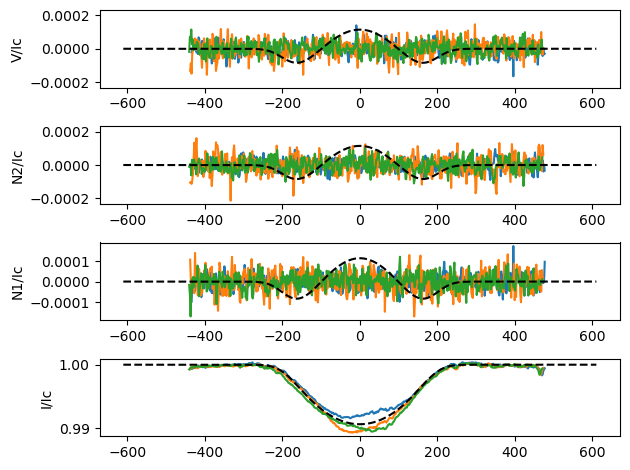

In [34]:
# make a copy of the parameters that are defined for the Stokes I fit
magparam = copy.copy(genparam)
# Add parameters for the dopolar field configuration
magparam['Bpole'] = 2500
magparam['incl'] = 90
magparam['beta'] = 90
magparam['phase'] = 90

param = param={'general' : magparam,
        'weak' : weakparam
       }

model = rav.diskint.numerical(param)

# Make a graph of the Scaled LSD profiles in the data Packet
fig, ax = Packet.scaled.plot()
# Overplot the calculated model
ax[3].plot(model['vel'], model['flux'], ls='--', c='k')
for item in ax.flatten()[0:3]:
       item.plot(model['vel'], model['V'], ls='--', c='k')

### 2.3 Determining the limits on the inclination based on vsini and critical velocity

There are two reasons to limit the range of inclinations in the bayesian grid. 

1. The default prior probability distribution used in pyRaven is a sin(i) distribution, to reflect the expected randomness of the rotational axis with respect to Earth. This means that the prior probability density at 0 and 180 degree will be exactly zero. 

    This in itself is not a scientific issue. However, because of the large range of values encoutered in probability densities, all of the calculation are done in logarithmic space. Python does not mind too much, as the transformation from ln(P) to P during marginalization and normalization have been designed to avoid overflow. Very underflow probability densities are handeled as -inf in log space, and return 0 when exponentiated. 
    
    However, this procedure will return a `division by zero` warning. Additionally, the `BayesObjects.exp_check()` and `BayesObject.ln_mar_check()` used throughout the code will also return a direct warning that a `nan` or `inf` was encountered, so that you can verify that this did not happen for an unexpected reason. 
    
    In principle, this should not happen, as there is also a physical reason for the grid of inclination not to go to 0 or 180.

2. If the star has a non-zero mesured $v_\mathrm{eq}\sin i$, then the incliation $i$ cannot be strighly $0^\circ$ or $180^\circ$. 

    One potential approach would be to determine the maximum equatorial velocity we deem possible (breakup velocity, perhaps), and use to the define a minimum inclination axis. 

    For example in the MiMeS Survey of O-type stars (Petit+2019), we set a very conservative upper limit of 700 km/s for $v_\mathrm{eq}$, and the minimum inclination value was set for each star in the sample according to its measured $v_\mathrm{eq}\sin i$. 

    In our example here, we set $v_\mathrm{eq}\sin i=200$ km/s. If we set a conservative maximum $v_\mathrm{eq}=700$ km/s, this implied that $i>17^\circ$, and we can set our inclination grid to be between $17^\circ$ and $163^\circ$. 

    We could be less conservative by setting a maximum $v_\mathrm{eq}$ that is closer to the typical breakup velocity of an O-type star (more like 300-400 km/s) - this would be less conservative because we will then be excluding a large range of potential inclination from the Bayesian parameter space. Of course, it is always possible to retrict the range of inclination after the calculations are done, but for the reason listed in #1 above, it is a good idea to always have some limits on the inclination angle grid to avoid using $i=0$. 

### 2.3 Setting up the grid 

Now that we have all of the information in hand, we can generate the <a href='../API/params.html#pyRaven.params.parameters'>`Parameters`</a> dictionary that will be use by the loop function. 

We need 3 sections in our <a href='../API/params.html#pyRaven.params.parameters'>`Parameters`</a> dictionary:
* `genparam`dictionary: the general parameters, same as we used for the `diskint.analytical` or `diskint.numerical` function. 
    :::{note} 
    The Bpole, incl, beta, and phase parameters are not necessary here, as they will be set by the gridparam structure. This said, one can still pass the `magparam` dictionary that we created in section 2.2 -- the extra parameters are simply ignored. 
    :::
* `weakparam`: the lande factor for the weak field approximation (see section 2.1)
* `gridparam`: contains the arrays defining the grid for the dipolar model parameters. 

::::{margin}
:::{note}
We here use a coarse grid for this tutorial, to save computing time and diskspace. 
:::
::::
The `gridparam` dictionary will contain 4 arrays that defines the desired values of 
* $B_\mathrm{pole}$ (`Bpole_grid`): we set an array from 0 to our desired $B_\mathrm{max}$ (5000G, sec. 2.2) with 25 grid points.
* $i$ (`incl_grid`): we set the grid to go from our minimum inclination (17°) to 180°-17°. 
* $beta$ (`beta_grid`): we set the grid to go from 0° to 180°. 
* the rotational phase (`phase_grid`): we set the grid to go from 0° to 360°, excluding 360° as it would be the same as 0°.

:::{tip}
1. The `np.arange` function will not create an array element at the upper boundary which can be used to our advantage to exclude 360° in our phase array. 
2. However, we need to both 0° and 180° in our $\beta$ array. Using the `np.arange` function, we need to set the upper bound of the array to a value larger than 180° (but smaller than 180°+step). 
3. It is advantageous to have the $\beta$ and $i$ grids to be symmetric around 90°. This is a bit more tricky to achive with `np.arange` in the case of the $i$. We therefore suggest to use `np.linspace` instead, and set the number of elements to be a value that will have a similar gridstep to that of the $\beta$ array. 
:::

:::{warning}
All of the angles, including the rotation phase, need to be in ***degrees***.
:::
 

In [35]:
gridparam = {
        'Bpole_grid': np.linspace(0,2500,50),
        'incl_grid': np.linspace(17,180-17,28), # 14 elements will give a grid step of roughly 10°
        'beta_grid': np.arange(0,181,5), # 5° per element, include 180°
        'phase_grid': np.arange(0,360,5) # 5° per element, excludes 360°
        }
    
param_loop={'general' : genparam,
       'weak' : weakparam,
       'grid' : gridparam
       }

We can save the parameters that will be used for the <a href='../API/loop.html#pyRaven.loop.loop'>`loop`</a> function into a json file. 

:::{tip}
This will be usedul if you would like to run the loop calculation (which can be time-consuming) on a unix/linux server -- you only need to transfer over the DataPacket object files, and the param dictionary files. 
:::

In [36]:
rav.params.parameters(param_loop).write('ExampleOutput/03-ChiSquareCalcLoop/param_loop.json')

## 3. Running the loop

So now, we have everything needed to run the loop, and it could be done with simply running

In [37]:
rav.loop.loop(param_loop, Packet, path='ExampleOutput/03-ChiSquareCalcLoop/LoopOutput/')

Using 9000.0 grid point on the surface
Max velocity needed: 30.0 vdop
Number of wavelength/velocity grid points: 621
Starting inclination loop 1/28
24.98656415939331
Starting inclination loop 2/28
23.540186166763306
Starting inclination loop 3/28
23.37093186378479
Starting inclination loop 4/28
22.83691430091858
Starting inclination loop 5/28
22.808455228805542
Starting inclination loop 6/28
23.251347064971924
Starting inclination loop 7/28
23.743130207061768
Starting inclination loop 8/28
23.522947788238525
Starting inclination loop 9/28
22.80844736099243
Starting inclination loop 10/28
23.92371916770935
Starting inclination loop 11/28
23.98340916633606
Starting inclination loop 12/28
23.768984079360962
Starting inclination loop 13/28
23.745951890945435
Starting inclination loop 14/28
24.65937376022339
Starting inclination loop 15/28
23.53124189376831
Starting inclination loop 16/28
22.64557409286499
Starting inclination loop 17/28
23.15404200553894
Starting inclination loop 18/28
23.

During the run, the function output the # of the current outer loop (over the inclinations) and give the time in seconds. Therefore it will give you an idea of how long it will take. 

It might be advantageous to run the loop on e.g. a cluster. 

To do this, you might find the <a href='../API/loop.html#pyRaven.loop.loop_wraper'>`loop_wraper`</a> function useful. 

If in a folder you already have:
- DataPacket.h5
- Params.json

From this folder, you can open python (and perhaps a `screen` instance in the terminal beforehand) and do:

````
import pyRaven as rav
rav.loop.loop_wrapper('param.json', 'ExamplePacket.h5')
````

which will load the Parameter dictionary and the DataPacket for you and will create the output files in the current directory (or an alternate location if you set the `path` keyword). 